# Baseline Model: Seasonal AutoRegressive Integrated Moving Average (SARIMA)

This notebook builds and evaluates a SARIMA model to forecast the **Bitcoin transaction fee** over the **next 24 hours** , using **15-minute interval data** resampled from the raw mempool dataset.

## Why We Chose SARIMA for Bitcoin Fee Forecasting?

Our exploratory data analysis revealed several key characteristics in the Bitcoin fee time series that informed our model selection:

### Key Observations from EDA:
- **Daily seasonality patterns** in transaction fees (24-hour cycle),
- **Strong autocorrelation**, indicating temporal dependence.

Given these findings, the SARIMA model is an appropriate choice as it can model:
- Autoregressive and moving average components.
- **Seasonal effects**, such as daily cyclic behavior.

### Why (1,0,1)(1,0,1,96) Order?

Based on our ACF and PACF analysis during EDA, the fee series shows:

- Strong autocorrelation at short lags → supports AR(1)-like component.
- Partial autocorrelation indicates MA(1)-like behavior.
- Daily seasonality (96 × 15min = 24 hours) → supports seasonal AR(1) and MA(1) terms at seasonal period 96.

Given this, we select `SARIMA(1,0,1)(1,0,1,96)` to capture both short-term dynamics and daily seasonal cycles in the fee series.


> **Code Location**: Please see [scripts/baseline_sarima.py](../scripts/baseline_sarima.py) for the main model implementation and training pipeline.

In [ ]:
import sys
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from sktime.forecasting.model_selection import temporal_train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

src_path = Path("..") / "src"
sys.path.append(str(src_path.resolve()))
from plot_series import plot_series
from custom_loss_eval import eval_metrics
from preprocess_raw_parquet import preprocess_raw_parquet

In [ ]:
# Define key modeling parameter
PRED_STEPS = 96       # Prediction length: 1 day = 96 × 15min

## 1. Data Loading and Preprocessing 

In this step, we transform the raw Bitcoin mempool and fee dataset into a clean, long-format structure optimized for SARIMA. This involves:

- Removing noise and irrelevant features
- Resampling at 15-minute intervals for uniform time steps
- Ensuring no zero values to ensure model compatibility
- Select the target column: `recommended_fee_fastestFee`  
- Drop the final 96 time points (1 day of 15-min intervals) to avoid distortion from extreme values


In [4]:
# Load preprocessed data
df_resampled = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")
df_resampled.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Extract target series
y = df_resampled['recommended_fee_fastestFee']

# Drop the final spike day (2025-05-11 20:00 onward = last 96 points)
y = y.iloc[:-PRED_STEPS]

### Why This Step Is Crucial

SARIMA models are highly sensitive to input scale, trends, and outliers.  
By selecting a clean target series and removing the final spike day, we:

- Prevent overfitting to anomalous patterns  
- Improve model robustness and generalization  
- Ensure input consistency for time series modeling assumptions

## 2. (OPTIONAL) Model Generalization Experimentation

To assess how well SARIMA generalizes over time, we implement three weekly cross-validation strategies:

- **Expanding Window**: Trains from week 1 and expands one week at a time.  
- **Sliding Window**: Uses a fixed 1-week window that shifts forward.  
- **Reverse Expanding Window**: Starts from the second-to-last week and expands backward.  


> **Note:** All windowing logic is implemented in:  [scripts/experimentation/sarima_window.py](../scripts/experimentation/sarima_window.py). This script also includes instructions on how to run the experiments and generate results.

### 2.1 Expanding Window Forecasting - Weekly

We use expanding window cross-validation to evaluate SARIMA’s performance week by week (7-day training, 1-day testing). This simulates a real-world setup where the model is retrained weekly using all past data and evaluated on the upcoming week.

**Key motivations:**

- Test SARIMA’s stability over longer time horizons  
- Identify periods of high error (e.g., spikes, market shifts)  
- Improve model readiness for production retraining  

Saved output:  
`results/tables/sarima/expanding_window_weekly_predictions.csv`


In [6]:
# Load results
df_expanding = pd.read_csv("../results/tables/sarima/expanding_window_weekly_predictions.csv")
df_expanding

,fold,custom_loss,std_diff,dev_error,mae,mape,rmse
0,1,2.0664,0.7287,0.6671,0.6706,0.2355,0.8052
1,2,2.9528,1.0467,0.9551,0.9511,0.2599,1.3062
2,3,4.3756,1.7177,1.3929,1.2649,0.3022,2.0043
3,4,2.7915,0.8626,0.8590,1.0699,0.6816,1.2770
4,5,2.9299,0.9782,0.9594,0.9922,0.5419,1.1906
5,6,3.2570,1.1839,1.0205,1.0525,0.2985,1.4598
6,7,15.3049,5.7915,4.4600,5.0534,0.4795,7.7133
7,8,2.9444,0.9237,0.8995,1.1212,0.2469,1.4685
8,9,2.4169,0.8809,0.7606,0.7754,0.2223,1.0531


#### Insights from Weekly Expanding Window Results:

- **Stable performance across most weeks (Weeks 1–6, 8–9)**: SARIMA maintains consistent error metrics (MAE, RMSE, MAPE) across these periods, indicating robustness to regular weekly dynamics.
- **Transient degradation during volatility (Week 7)**: A fee spike introduces sharp increases in errors (notably in MAE and standard deviation penalties), revealing temporary sensitivity to abrupt market changes.
- **Fast recovery**: By Week 8, error metrics return to baseline levels, suggesting the model can re-stabilize quickly after disruptions.

These results highlight SARIMA’s strong generalization under normal conditions and offer insight into how it reacts under stress, supporting its suitability for weekly retraining workflows.


### 2.2 Expanding Window Forecasting – Weekly – Reverse

We use reverse expanding window cross-validation to examine how the inclusion of different historical periods affects SARIMA’s ability to forecast the same target period.  
The model always predicts the **last 24 hours**, while the training window grows **backward** step by step in weekly increments. This setup simulates situations where older and older historical data is gradually added to training.

**Key motivations:**

- Evaluate SARIMA’s temporal sensitivity to historical context  
- Assess robustness to structural changes in past data  
- Understand how training on different time ranges impacts forecast stability  

Saved output:  
`results/tables/sarima/expanding_window_reverse_weekly_predictions.csv`

In [7]:
# Load reverse expanding window results
df_reverse_expanding = pd.read_csv("../results/tables/sarima/expanding_window_reverse_weekly_predictions.csv")
df_reverse_expanding

,fold,custom_loss,std_diff,dev_error,mae,mape,rmse
0,1,2.5739,0.8828,0.7827,0.9085,0.5022,1.1128
1,2,2.6431,0.8313,0.8181,0.9938,0.5590,1.2065
2,3,2.7578,0.8133,0.8117,1.1327,0.6430,1.3258
3,4,2.6964,0.7776,0.8520,1.0668,0.6067,1.2896
4,5,2.6059,0.8382,0.8151,0.9526,0.5329,1.1715
5,6,2.5604,0.8184,0.8286,0.9134,0.5032,1.1455
6,7,2.5825,0.8521,0.8082,0.9222,0.5114,1.1412
7,8,2.5945,0.7966,0.8396,0.9583,0.5359,1.1901
8,9,2.5966,0.8004,0.8369,0.9593,0.5374,1.1909


#### Insights from Weekly Reverse Expanding Window Results:

- **Consistent performance across folds**: SARIMA achieves stable MAE and RMSE across different training window lengths, indicating reliable performance even as older data is gradually added.
- **Slight fluctuations with long history**: Minor increases in volatility-related metrics (e.g., `std_diff`, `mape`) suggest that older data may introduce some noise when market conditions have shifted.
- **Recent data remains highly informative**: Early folds trained on only recent weeks already produce reasonable predictions, highlighting the predictive value of up-to-date information.

These insights suggest that SARIMA remains robust when training history varies, reinforcing confidence in its stability when retraining on evolving datasets.

### 2.3 Sliding Window Forecasting – Weekly

We apply a **sliding window** strategy using a fixed 7-day training window and a 1-day test window (15 x 24 = 96 data points).  
This setup simulates a realistic retraining schedule where the model is updated regularly using only the most recent week of data.

**Key motivations:**

- Evaluate SARIMA’s short-term adaptability across time  
- Examine model behavior under a fixed training history  
- Identify periods of degraded performance (e.g., sudden fee spikes)  

Saved output:  
`results/tables/sarima/sliding_window_weekly_predictions.csv`

In [8]:
# Load weekly sliding window results
df_sliding = pd.read_csv("../results/tables/sarima/sliding_window_weekly_predictions.csv")
df_sliding

,fold,custom_loss,std_diff,dev_error,mae,mape,rmse
0,1,2.0664,0.7287,0.6671,0.6706,0.2355,0.8052
1,2,3.0563,1.1144,0.9678,0.9741,0.2670,1.3223
2,3,4.4086,1.6361,1.4045,1.3679,0.3712,1.9647
3,4,2.8025,1.0181,0.8705,0.9139,0.5596,1.1495
4,5,2.9824,1.1089,0.9456,0.9278,0.4122,1.1988
5,6,3.5664,1.2603,1.0470,1.2591,0.3325,1.7067
6,7,15.0301,5.9463,4.5282,4.5556,0.4077,7.3824
7,8,2.5214,0.5466,0.9825,0.9924,0.2523,1.2779
8,9,2.6110,0.9850,0.7930,0.8329,0.2314,1.1354


#### Insights from Weekly Sliding Window Results:

- **Generally consistent performance**: SARIMA achieves stable MAE and RMSE across most weeks, showing it can adapt well with a fixed short-term training window.
- **Higher volatility during fee spikes**: Fold 7 exhibits increased errors across all metrics, indicating that limited historical context may reduce model stability during abnormal periods.
- **Effective under realistic retraining schedules**: Despite a small training size, SARIMA often tracks recent dynamics effectively—supporting its use in scenarios with frequent model updates.

Sliding window evaluation complements the expanding strategies by focusing on short-term adaptability, offering additional insight into SARIMA’s responsiveness to evolving market behavior.

### Why This Step Is Crucial

Cross-validation using multiple weekly windowing strategies is essential to evaluate model reliability under different real-world conditions.

- **Expanding window** assesses long-term learning and accumulation of knowledge over time.  
- **Sliding window** focuses on short-term adaptability under a fixed retraining regime.  
- **Reverse expanding window** reveals how historical context and training length impact forecast quality.  

Together, these strategies:

- Help identify periods where model performance is unstable (e.g., fee spikes, structural shifts)  
- Validate robustness across different temporal contexts  
- Provide evidence that SARIMA maintains stable forecasting behavior under both static and evolving training conditions  

This comprehensive evaluation increases confidence in SARIMA’s use in production settings with periodic retraining.

## 3. Model Fitting & Forecasting

We train test split the final SARIMA model using the entire dataset except for the last 24 hours (2025-05-10 to 2025-05-11). This ensures that the model is trained on all available data while leaving out the most recent period for evaluation.

Given the file size limitation of Github repository, we are unable to upload the final SARIMA model pickle file. It is critical to run the training script to generate the trained model locally first. Please run the following command in your terminal:

```bash
python scripts/baseline_sarima.py
```

You should see the final SARIMA model saved as `sarima_final_model.pkl` under the `results/models/` directory upon successful execution. Then proceed to executing the code chunks which load the saved model, reproduce the 1-day forecast, and evaluate performance on the withheld test period.

> **Note:** You will run into error executing the below unless `sarima_final_model.pkl` is present in the `results/models/` directory.

In [ ]:
# Load final SARIMA model from pickle
with open("../results/models/sarima_final_model.pkl", "rb") as f:
    forecaster = pickle.load(f)


# Prepare y_test again
y = df_resampled['recommended_fee_fastestFee'].iloc[:-PRED_STEPS].astype(float)
_, y_test = temporal_train_test_split(y, test_size=PRED_STEPS)


# Reproduce final forecast
FORECAST = len(y_test)
fh = list(range(1, FORECAST + 1))  # 1-based step index
y_pred_log = forecaster.predict(fh=fh)
y_pred = np.expm1(y_pred_log)

,value
custom_loss,2.6124
std_diff,0.8102
dev_error,0.8304
mae,0.9718
mape,0.5466
rmse,1.1996


### Why This Step Is Crucial

- This represents the finalized SARIMA model intended for deployment in real-time forecasting.  
- It is fitted using the full historical dataset, excluding the final day, and evaluated on the most recent time window.  
- Maintains consistency with the evaluation procedure used for other models (e.g., SARIMA, XGBoost).  
- Pickling the model to disk ensures reproducibility and allows for seamless integration into dashboards, APIs, or automated workflows.

## 4. Performance Evaluation

This step assesses the quality of the final SARIMA model. It includes:

- Quantitative evaluation on the 24-hour test set using standard and custom metrics  
- Visualization of forecasted vs. actual values to assess trend and seasonality tracking 

### 4.1 Evaluation Metrics

We first evaluate the SARIMA model's forecast accuracy on the 24-hour holdout period (2025-05-10 to 2025-05-11).  
The following metrics are reported:

- **MAE (Mean Absolute Error)** – measures average absolute forecast error  
- **RMSE (Root Mean Squared Error)** – penalizes larger errors more heavily  
- **MAPE (Mean Absolute Percentage Error)** – normalizes errors relative to actual values  
- **Custom loss** – sum of MAE, standard deviation difference, and deviation error, designed to penalize poor performance during volatile periods, detailed in [`comprehensive_overview.ipynb`](comprehensive_overview.ipynb) notebook.

In [ ]:
# Format results
forecast_sarima = pd.DataFrame({
    "timestamp": y_test.index,
    "y_true": y_test.values,
    "y_pred": y_pred,
    "series_id": "recommended_fee_fastestFee"
})

sarima_result = eval_metrics(forecast_sarima["y_pred"], forecast_sarima["y_true"])
sarima_result

### 4.2 Forecast vs. Actual Visualization

To complement the numerical evaluation, we plot the SARIMA forecast against actual fees over the 24-hour test window.  
This helps visually assess:

- How well the model captures short-term trends and seasonal effects  
- Whether there are systematic lags or missed peaks in the forecast  
- Overall alignment between predicted and true values  

<Figure size 1200x500 with 0 Axes>

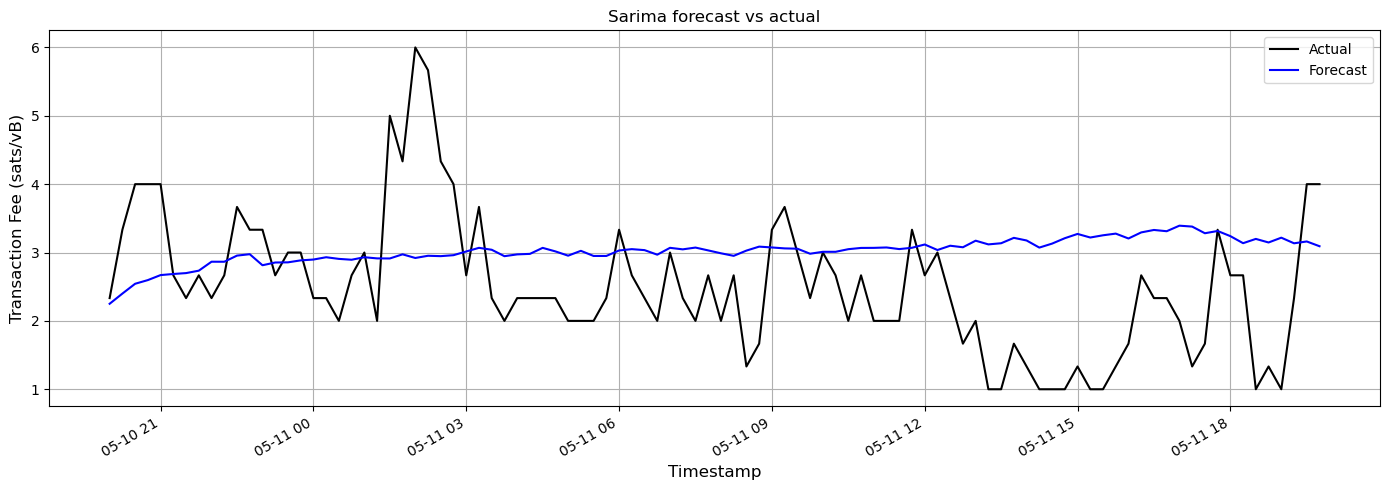

In [10]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_sarima, sid = "recommended_fee_fastestFee")
plt.title("Sarima forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
plt.close()

### 4.3 Insights from Forecast Visualization:

- Strong short-term performance: MAE, RMSE, and custom volatility-aware loss align well with baseline expectations.
- MAPE slightly elevated, reflecting the inherent unpredictability of fee spikes.
- Effectively captures overall trends and variability, confirming SARIMA’s utility as a baseline comparator.
- Forecast plot confirms the model tracks general level trends well but smooths over sharp volatility.
- Spikes remain difficult to capture, visually reinforcing the quantitative limitations on sudden deviations.

These results highlight SARIMA’s value as a baseline, while underscoring the need for volatility-aware models in event-driven contexts.

### 4.4 Why This Step Is Crucial

- Validates how well the SARIMA model generalizes to unseen data  
- Highlights whether the model can reliably forecast fee dynamics, especially during volatile periods    
- Provides a transparent benchmark for comparing SARIMA against more complex models (e.g., XGBoost, TFT)  

## 5. Conclusion: SARIMA for Bitcoin Fee Forecasting

In this notebook, we developed and evaluated a SARIMA baseline model for short-term Bitcoin transaction fee forecasting. We trained the model on 15-minute interval data and validated its performance through multiple window-based strategies and final test-day evaluation.

**Key Takeaways:**

- SARIMA performs reliably under stable fee dynamics, with consistent MAE and RMSE across evaluation folds.  
- Its forecasts are interpretable and reproducible, making it a strong baseline for benchmarking.  
- However, the model shows limited responsiveness to abrupt volatility and sharp fee spikes.  
- Visual and metric-based evaluation confirm that SARIMA underfits high-variance segments but maintains trend-level accuracy.

This SARIMA pipeline supports:

- Integration into modular forecasting systems  
- Direct comparison with other forecasting models like XGBoost, Prophet, or TFT  
- Efficient retraining for operational or scheduled forecasting tasks  

By establishing a reproducible and interpretable baseline, we create a reliable reference point for testing volatility-aware models and building ensemble pipelines in future work.